# A LITTLE CHAT GOES A LONG WAY: HANDS-ON TUTORIAL ON CONVERSATIONAL INFORMATION ACCESS - (HANDS-ON)

### Tutorial on Joint Conversational Search and Recommendation at ECIR 2025, 04th April, Lucca, Italy

Guglielmo Faggioli, Nicola Ferro, Simone Merlo

# CoSRec

CosRec is a dataset specifically built for Joint Conversational Search and Recommendation (CSR).


This dataset has been created to fit with both modular and unified systems,thus, it provides:
 - conversations
 - items catalogue AND document corpus
 - user data
 - ground truths



### Example of a CoSRec Conversation
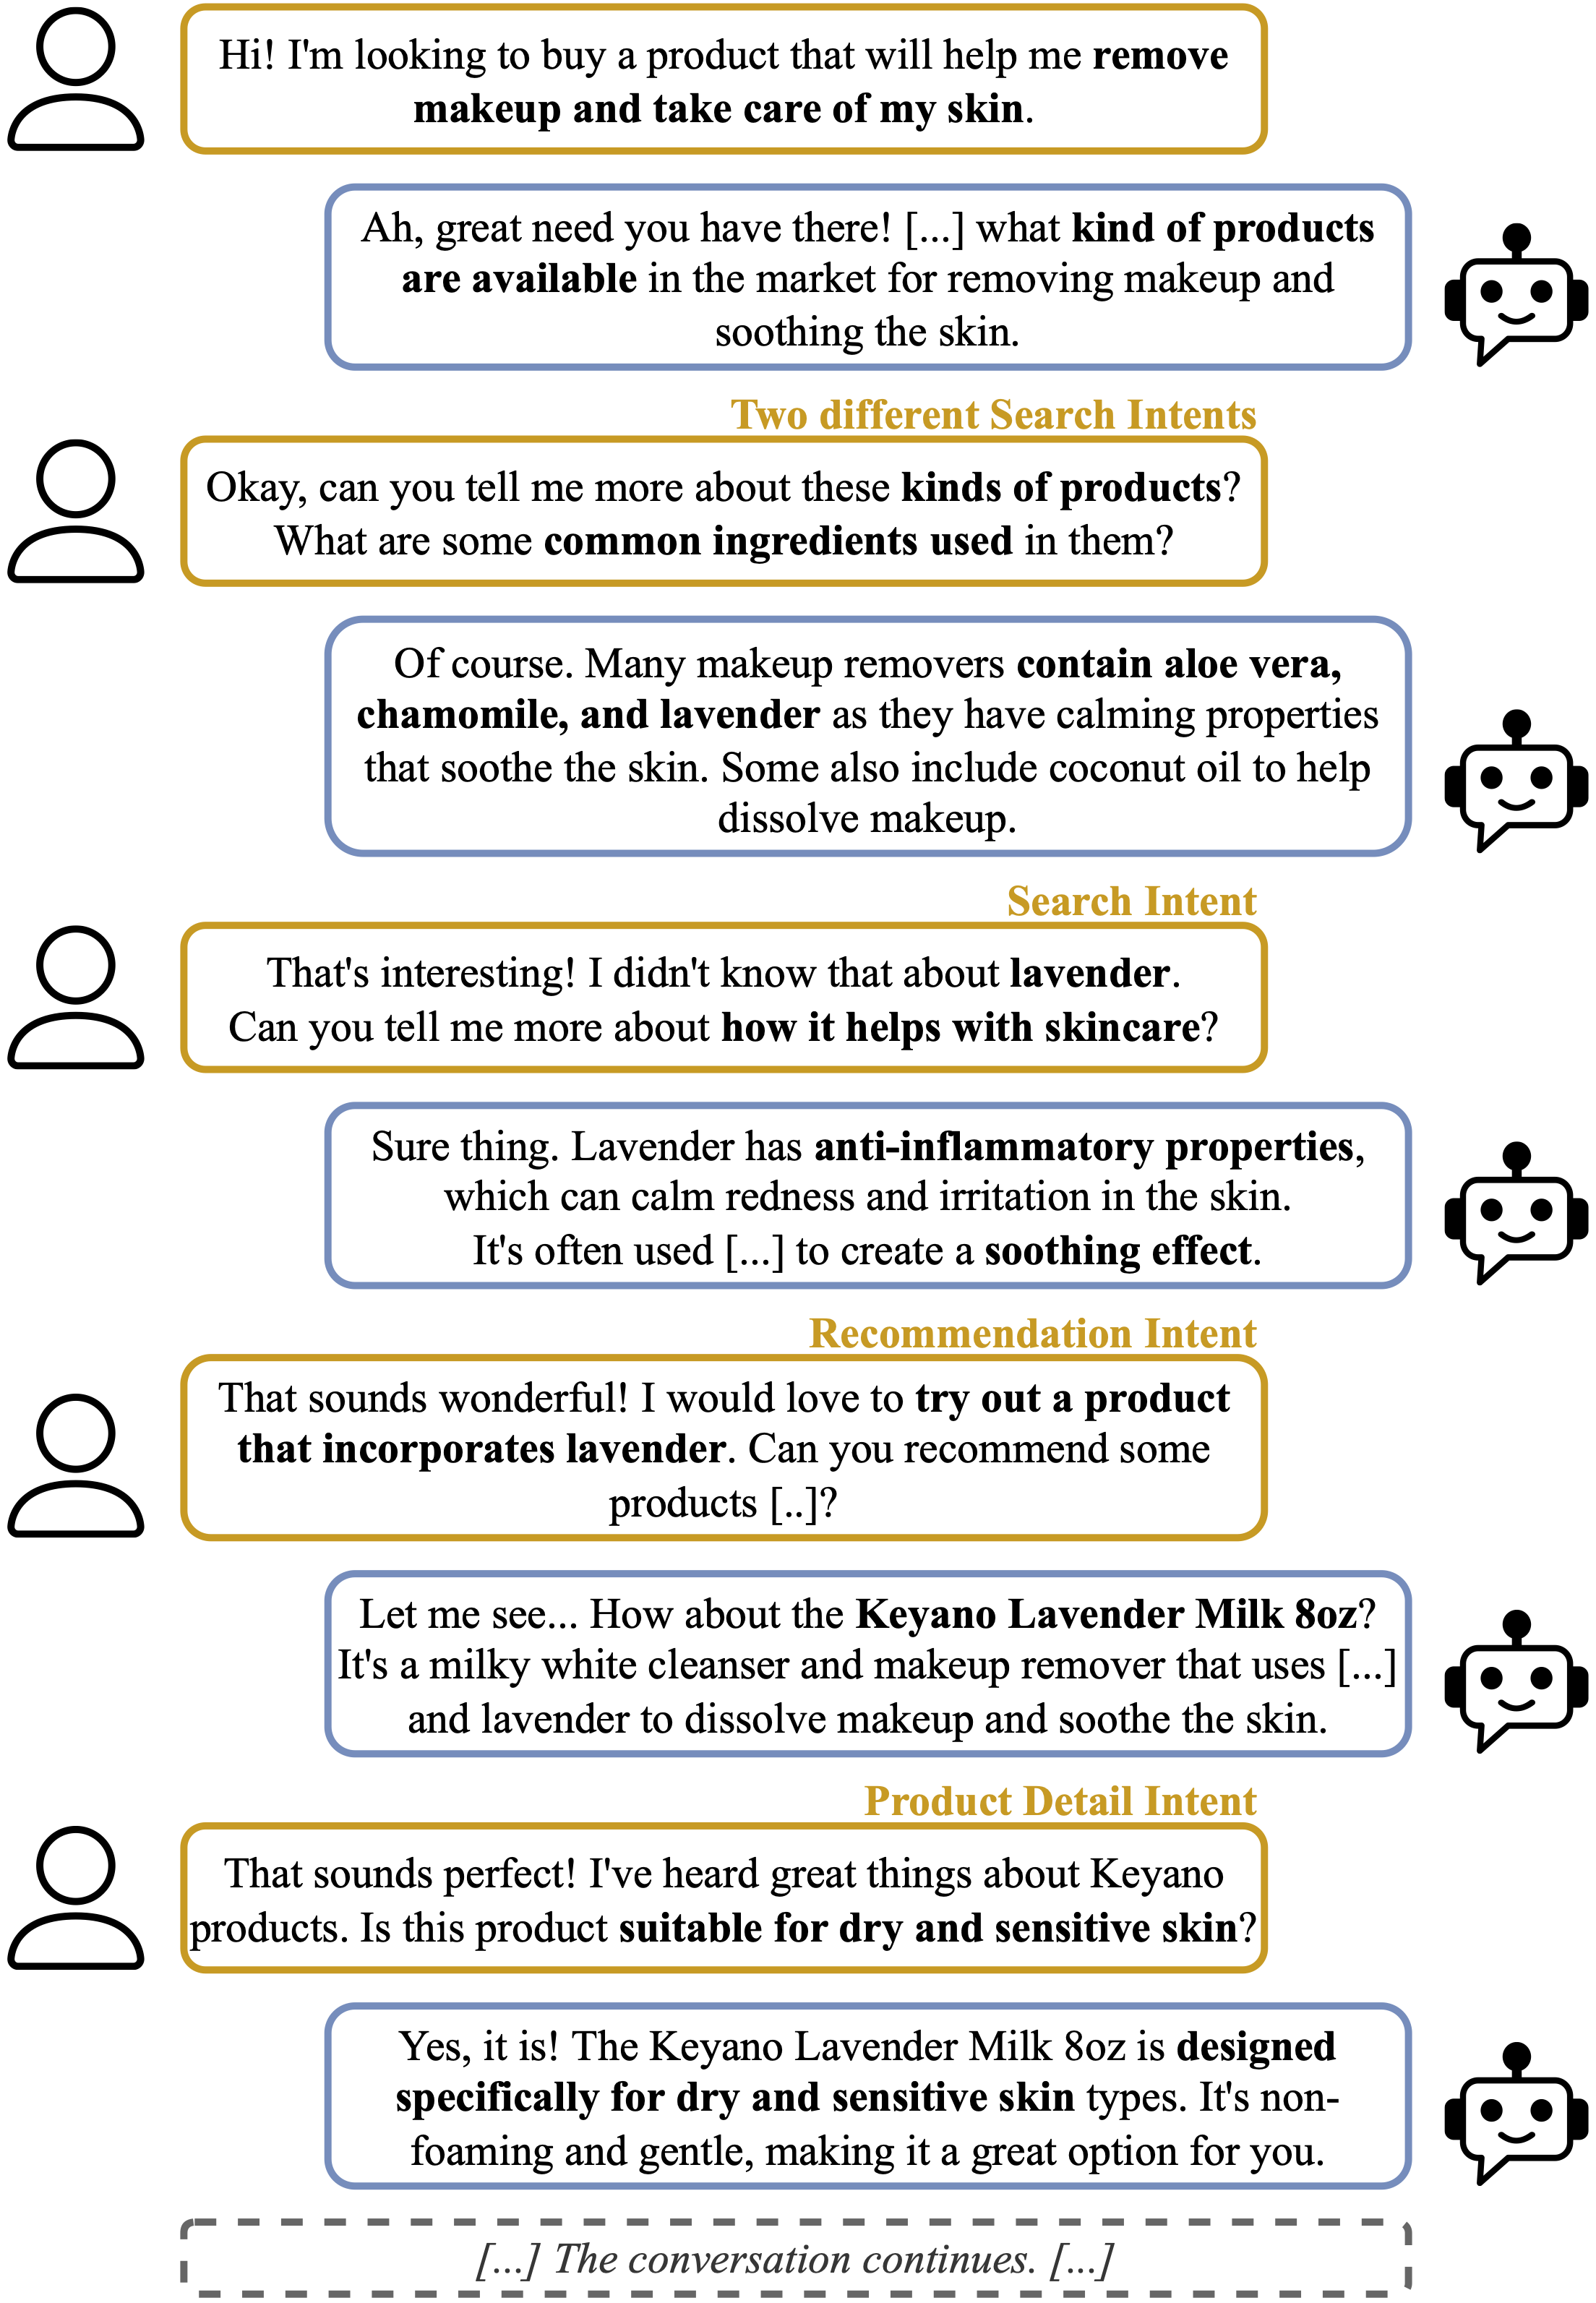

## CoSRec Structure

Following the standard IR test collection structure CoSRec contains:

- **Information Needs**
  - **Conversations**
  - **User Profiles**
- **Corpora**
  - **MS-Marco v2.1**
  - **Amazon Reviews**
- **Human Annotations**
  - **Conversations Qualit Assessments**
  - **Intent Labels**
  - **Relevance Judgments**




<br>
<br>
<br>


#### Partitions
CoSRec includes 9,249 conversations split into 3 partitions:
<table style="font-size: 50px;">
<tr>
<th>Partition</th>
<th># Conversations</th>
<th># Utterances</th>
<th>Human Annotated</th>
<th>Curated</th>
</tr>
<tr>
<td><strong>CoSRec-Raw</strong></td>
<td>8,938</td>
<td>71,656</td>
<td></td>
<td></td>
<tr>

<tr>
<td><strong>CoSRec-Crowd</strong></td>
<td>291</td>
<td>2,329</td>
<td>X</td>
<td></td>
<tr>

<tr>
<td><strong>CoSRec-Curated</strong></td>
<td>20</td>
<td>150</td>
<td>X</td>
<td>X</td>
<tr>
</table>



## Corpora

- **MS-Marco v2.1**: IR corpus composed of 113.5M passages, used to support **search**

- **Amazon Reviews**: Recommendation dataset containing product metadata and user reviews, used to support **recommendation**.


**NOTE**: to build and use CoSRec a filtered version of Amazon Reviews needs to be exploited.
If you want to use the entire AmazonReviews dataset download all the files available at [ https://amazon-reviews-2023.github.io/#grouped-by-category ] and place the metadata and reviews files in the AmazonReviews/meta and AmazonReviews/reviews folders, respectively.




**Step 0**: libraries

In [ ]:
import os
import numpy as np
import json
from termcolor import colored
import gzip
import operator
!pip install colorama
import colorama
from colorama import Fore,Back

**Step 1.a**: we download a reduced version of the Amazon Reviews dataset

In [ ]:
!gdown 1qDrGB5mNWagPK2XKEB-H0Vjifw_c0H6R

!unzip /content/AmazonReviews.zip


os.environ['DATA'] = '/content/AmazonReviews'

Downloading...
From: https://drive.google.com/uc?id=1qDrGB5mNWagPK2XKEB-H0Vjifw_c0H6R
To: /content/AmazonReviews.zip
100% 138k/138k [00:00<00:00, 66.5MB/s]
Archive:  /content/AmazonReviews.zip
   creating: AmazonReviews/
  inflating: AmazonReviews/.DS_Store  
  inflating: __MACOSX/AmazonReviews/._.DS_Store  
   creating: AmazonReviews/meta/
   creating: AmazonReviews/reviews/
  inflating: AmazonReviews/meta/product_metadata.jsonl.gz  
  inflating: __MACOSX/AmazonReviews/meta/._product_metadata.jsonl.gz  
  inflating: AmazonReviews/reviews/reviews_metadata.jsonl.gz  
  inflating: __MACOSX/AmazonReviews/reviews/._reviews_metadata.jsonl.gz  


**Step 1.b**: User Data (User Histories)

In [ ]:
import pandas as pd
users_history = {}
ctr_verified = 0
ctr_not_verified = 0
reviews_folder=f"{os.environ['DATA']}{os.sep}reviews"
outfile=f"{os.environ['DATA']}{os.sep}user_history.jsonl.gz"
# ------------------------------------------------------------------------------------------------------------------
# Loop through all gzip-compressed jsonl archives that contain the reviews.
# ------------------------------------------------------------------------------------------------------------------
for sf in sorted(os.listdir(reviews_folder)):
    # Do not consider files which are NOT gzip-compressed jsonl archives.
    if not sf.endswith(".jsonl.gz"):
        continue

    ctr_partial_verified = 0
    ctr_partial_not_verified = 0

    # --------------------------------------------------------------------------------------------------------------
    # Extract data from the current source reviews gzip-compressed file.
    # --------------------------------------------------------------------------------------------------------------
    with gzip.open(f"{reviews_folder}/{sf}", "rt") as fi:
        for line in fi:
            try:
                # Extract relevant data from the current review.
                data = json.loads(line)
                user = data["user_id"]
                product = data["parent_asin"]
                timestamp = int(data["timestamp"])

                rating = int(round(data["rating"] + 0.001))
                # assert 1 <= rating <= 5
                if not (1 <= rating <= 5):
                    print(f"Rating error: {type(data['rating'])}: {data['rating']}")
                    continue

                verified_purchase = bool(data["verified_purchase"])

                if verified_purchase:
                    ctr_partial_verified += 1
                else:
                    ctr_partial_not_verified += 1

                # Add the current data to the user history.
                inner_list = users_history.get(user, [])
                inner_list.append((product, timestamp, rating, verified_purchase))
                users_history[user] = inner_list

                del data, user, product, timestamp, rating, verified_purchase, inner_list
            except json.JSONDecodeError:
                print("json.JSONDecodeError")
                pass
            except KeyError:
                print("KeyError")
                pass
            except ValueError:
                print("ValueError")
                pass

    print(f"{sf} => Verified: {ctr_partial_verified}  -  NOT verified: {ctr_partial_not_verified}")
    ctr_verified += ctr_partial_verified
    ctr_not_verified += ctr_partial_not_verified

print(f"TOTAL => Verified: {ctr_verified}  -  NOT verified: {ctr_not_verified}")

# --------------------------------------------------------------------------------------------------------------
# Write the user history to jsonl file on disk.
# --------------------------------------------------------------------------------------------------------------
fo = gzip.open(outfile, "wt", encoding="utf-8")
with fo:
  for user, v in sorted(users_history.items(), key=operator.itemgetter(0), reverse=False):
    # Sort by the timestamp associated the list of products purchased by the user.
    v = sorted(v, key=operator.itemgetter(1), reverse=False)

    print(json.dumps({
      "user": user,
      "history": [{
      "product": x[0],
      "timestamp": x[1],
      "rating": x[2],
      "verified_purchase": x[3]
    } for x in v]
    }), file=fo, flush=True)

print(json.dumps({k: users_history[k][:5] for k in list(users_history.keys())[:2]},indent=4))


#CREATING A DATAFRAME --> JUST FOR VISUALIZATION PURPOSES
user_history_to_df={'user':[],'product':[],'timestamp':[],'rating':[],'verified_purchase':[]}
for user,v in sorted(users_history.items(), key=operator.itemgetter(0), reverse=False):
  for review in v:
    user_history_to_df['user'].append(user)
    user_history_to_df['product'].append(review[0])
    user_history_to_df['timestamp'].append(review[1])
    user_history_to_df['rating'].append(review[2])
    user_history_to_df['verified_purchase'].append(review[3])

df_user_history=pd.DataFrame(user_history_to_df)
df_user_history

reviews_metadata.jsonl.gz => Verified: 144  -  NOT verified: 5
TOTAL => Verified: 144  -  NOT verified: 5
{
    "AH335EVIHZK2GDXEU7NC2ZPZZ5HQ": [
        [
            "B07F2WLSRP",
            1650826165422,
            2,
            true
        ],
        [
            "B08NWG7Q21",
            1619825290947,
            4,
            true
        ],
        [
            "B0C5SLXZSN",
            1603659729248,
            5,
            true
        ],
        [
            "B08DPJR923",
            1594487665092,
            2,
            true
        ],
        [
            "B07KYTKWY3",
            1588440744793,
            4,
            true
        ]
    ],
    "AEZATPX6XIW7MMJ7YBIWPLYA4QCQ": [
        [
            "B09P2SCNZ3",
            1571431904150,
            5,
            true
        ],
        [
            "B004CIK628",
            1571432448599,
            5,
            true
        ],
        [
            "B000C7S5EO",
            1571432331337,
     

,user,product,timestamp,rating,verified_purchase
0,AEZATPX6XIW7MMJ7YBIWPLYA4QCQ,B09P2SCNZ3,1571431904150,5,True
1,AEZATPX6XIW7MMJ7YBIWPLYA4QCQ,B004CIK628,1571432448599,5,True
2,AEZATPX6XIW7MMJ7YBIWPLYA4QCQ,B000C7S5EO,1571432331337,5,True
3,AEZATPX6XIW7MMJ7YBIWPLYA4QCQ,B000C7RZ2C,1571432305273,5,True
4,AEZATPX6XIW7MMJ7YBIWPLYA4QCQ,B004IARQ1Y,1571432158446,5,True
...,...,...,...,...,...
144,AH335EVIHZK2GDXEU7NC2ZPZZ5HQ,B07YVQ4WPL,1593988642157,3,True
145,AH335EVIHZK2GDXEU7NC2ZPZZ5HQ,B07G3Z9NL2,1544730176999,4,True
146,AH335EVIHZK2GDXEU7NC2ZPZZ5HQ,B01N8X154C,1536585590918,3,True
147,AH335EVIHZK2GDXEU7NC2ZPZZ5HQ,B003N5ZCW0,1367819163000,4,True


## Conversations

**Generation Pipeline**:

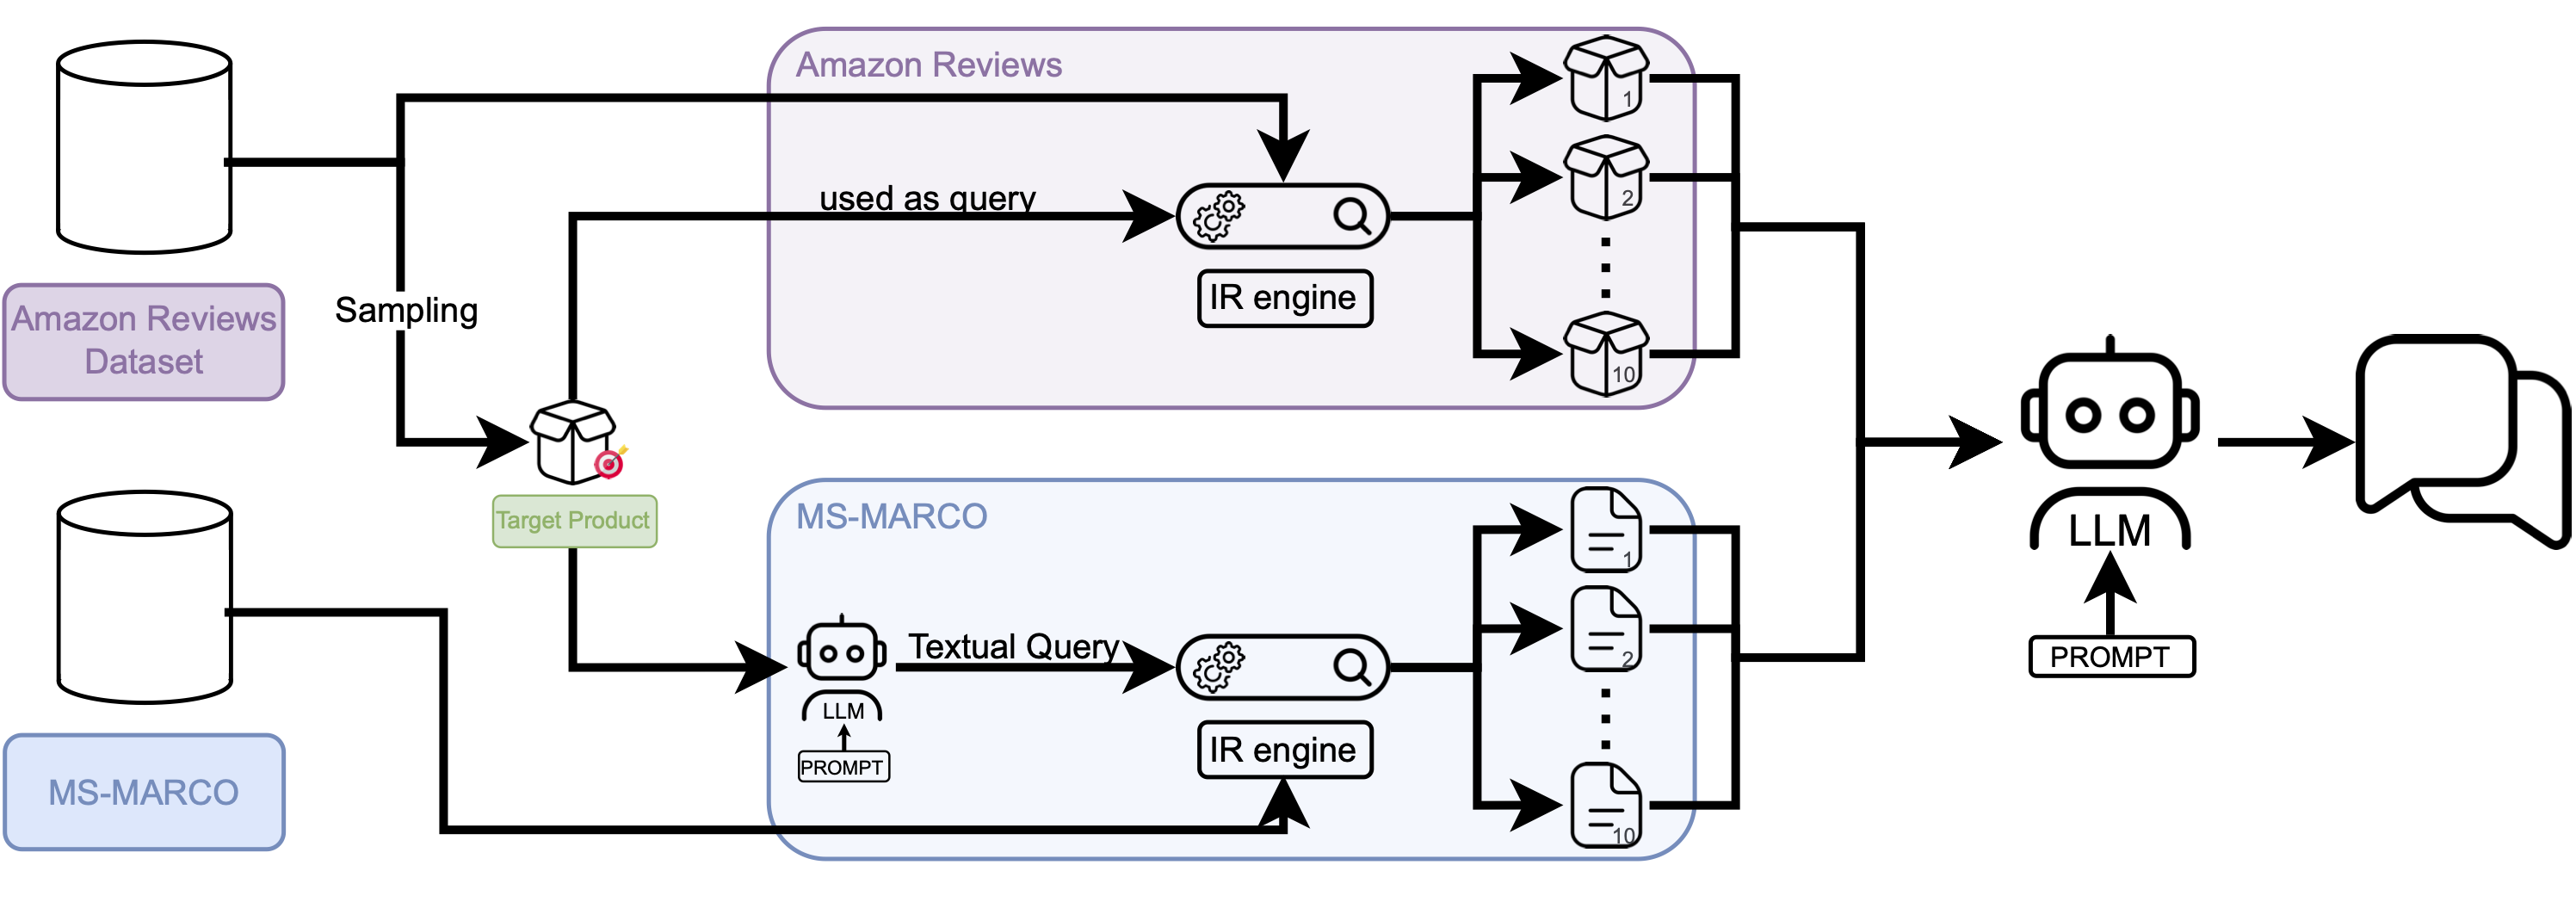


**Step 2.a**: we download the CoSRec dataset.

In [ ]:
!wget https://github.com/CAMEO-22/CoSRec/archive/refs/heads/main.zip

!unzip /content/main.zip

os.environ['COSREC'] = '/content/CoSRec-main/dataset'
os.environ['COSREC_CURATED'] = f"{os.environ['COSREC']}{os.sep}curated"

--2025-04-02 10:01:58--  https://github.com/CAMEO-22/CoSRec/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/CAMEO-22/CoSRec/zip/refs/heads/main [following]
--2025-04-02 10:01:58--  https://codeload.github.com/CAMEO-22/CoSRec/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [  <=>               ]   7.63M  6.28MB/s    in 1.2s    

2025-04-02 10:01:59 (6.28 MB/s) - ‘main.zip’ saved [8006218]

Archive:  /content/main.zip
10572700a7e48e0ab51b3acf59ccf9ecc28f42f4
   creating: CoSRec-main/
  inflating: CoSRec-main/README.md   
   creating: CoSRec-main/da

**Step 2.b**: accessing the conversations

In [ ]:
conversations={}
with open(f"{os.environ['COSREC_CURATED']}{os.sep}conversations.jsonl") as fi:
  for line in fi:
    conversation=json.loads(line)
    print(conversation)
    conversations.update(conversation)

print("Total Number of Conversations:", len(conversations))



#CREATING A DATAFRAME --> JUST FOR VISUALIZATION PURPOSES
conversation_df=pd.DataFrame.from_dict(conversations, orient='index')
conversation_df


{'CoSRec-Curated_1': "U: Hi, I'm looking to buy some premium rubber floor car mats for my Jeep Cherokee.\nS: Great choice! Premium rubber floor car mats are a fantastic way to protect your vehicle's interior from dirt, water, and other debris. What specific features are you looking for in these mats?\nU: Well, I'd like them to be made of high-quality rubber that can withstand sub-zero temperatures and hold up to 1-2 quarts of liquid without spilling.\nS: That sounds like a good starting point! From what I know, some premium rubber floor car mats are made with a non-stick finish for quick cleanup. However, their effectiveness in cold weather might vary. Would you like me to show you some options that fit your requirements?\nU: Yes, please do! Can you tell me more about the different types of rubber used in these mats? I've heard some are more durable than others.\nS: Of course! Some premium rubber floor car mats are made with a heavier-duty rubber that's designed to withstand harsh cond

,0
CoSRec-Curated_1,"U: Hi, I'm looking to buy some premium rubber ..."
CoSRec-Curated_2,"U: Hi, I'm looking to buy a product that will ..."
CoSRec-Curated_3,"U: Hi, I'm looking to buy a product to satisfy..."
CoSRec-Curated_4,U: Hi! I'm looking to buy a product to satisfy...
CoSRec-Curated_5,"U: Hi, I'm looking to buy a product that can h..."


In [ ]:
for c_id, c_text in conversations.items():
  print()
  print(Fore.BLACK+c_id,":")
  utterances=c_text.split("\n")   #SPLITTING THE CONVERSATION INTO UTTERANCES
  for utterance in utterances:
    if utterance.startswith("U:"):
      print("\t", Fore.BLUE + utterance)
    else:
      print("\t", Fore.RED + utterance)


CoSRec-Curated_1 :
	 U: Hi, I'm looking to buy some premium rubber floor car mats for my Jeep Cherokee.
	 S: Great choice! Premium rubber floor car mats are a fantastic way to protect your vehicle's interior from dirt, water, and other debris. What specific features are you looking for in these mats?
	 U: Well, I'd like them to be made of high-quality rubber that can withstand sub-zero temperatures and hold up to 1-2 quarts of liquid without spilling.
	 S: That sounds like a good starting point! From what I know, some premium rubber floor car mats are made with a non-stick finish for quick cleanup. However, their effectiveness in cold weather might vary. Would you like me to show you some options that fit your requirements?
	 U: Yes, please do! Can you tell me more about the different types of rubber used in these mats? I've heard some are more durable than others.
	 S: Of course! Some premium rubber floor car mats are made with a heavier-duty rubber that's designed to withstand harsh

## User Profiles

For each conversation, **3 users** which reviewed (bougth) an item (randomly sampled) used to generate it **are sampled**

For each user we exploit its 10 reviews (posted before reviewing the item considered) to generate:

- **user profile summary**
- **user profile keywords**

Which summarize the user interests.


LLMs Were employed for this purpose.

**Step 3.a**: accessing the user profiles and keywords

In [ ]:
conversations_profiles={}
conversations_to_users={}
users_to_profile={}
ctr=0
with open(f"{os.environ['COSREC_CURATED']}{os.sep}profiles.jsonl") as fi:
  for line in fi:
    profiles=json.loads(line)                       #PARSING THE LINE
    print(profiles)

    conversation_id=list(profiles.keys())[0]        #GETTING THE CONVERSATION ID

    conversations_profiles.update(profiles)

    conversations_to_users[conversation_id]=[]

    for user_id, user_profile in list(profiles.values())[0].items():   #MAPPING USER <-> PROFILE and CONVERSATION <-> USER
        conversations_to_users[conversation_id].append(user_id)   #CONVERSATION <-> USER
        users_to_profile[user_id]={}                              #USER <-> PROFILE
        users_to_profile[user_id]['summary']=[user_profile]       #USER --> summary -->
                                                                  #We "wrap" the profile into a list for "consistency" with the keywords, see next cell



print("Total Number of Conversations:", len(conversations_profiles))

print("Total Number of Users:", len(users_to_profile))





{'CoSRec-Curated_1': {'AF6X6OG5V2GI6NET377IBCY6QWHA': 'A middle-aged to young adult individual who values convenience, comfort, and quality in their daily life. They likely have children at home and prioritize products that are durable, easy to use, and suitable for family needs. This person appreciates value for money and has moderate expectations from the products they purchase, often looking for something that "works perfectly" or is "perfect" but may not be too concerned with high-end features or exceptional performance.', 'AFNCQF6OQMA5I3QHUZCTC32HT4MA': 'Foodie, health-conscious Southern American woman in her 40s or 50s, likely living in the United States, who values high-quality products, appreciates traditional and nostalgic items, and prioritizes convenience, ease of use, and natural ingredients. She enjoys cooking and preparing boiled peanuts, has a fondness for peanut butter and sunflower seed butter, and is likely busy with family and farm-related activities.', 'AFXSR3VPB5JF

In [ ]:
conversations_keywords={}

with open(f"{os.environ['COSREC_CURATED']}{os.sep}keywords.jsonl") as fi:
  for line in fi:
    keywords=json.loads(line)                       #PARSING THE LINE
    print(keywords)

    conversation_id=list(profiles.keys())[0]        #GETTING THE CONVERSATION ID

    conversations_keywords.update(keywords)

    for user_id, user_keywords in list(keywords.values())[0].items():   #MAPPING USER <-> KEYWORDS
        users_to_profile[user_id]['keywords']=user_keywords   #USER --> keywords --> [list of keywords]



print("Total Number of Conversations:", len(conversations_keywords))

ctr=0
for user, profile in users_to_profile.items():
  ctr+=len(profile['keywords'])

print("Total Number of Keywords:", ctr)

{'CoSRec-Curated_1': {'AF6X6OG5V2GI6NET377IBCY6QWHA': ['cheap', 'durable', 'robust', 'perfect'], 'AFNCQF6OQMA5I3QHUZCTC32HT4MA': ['quality', 'value', 'robustness', 'ease of use'], 'AFXSR3VPB5JF54C5B3U4AQMCDNLQ': ['quality', 'price', 'durability', 'protection']}}
{'CoSRec-Curated_2': {'AEIRQLNGXMDGYFBRTF7A6RAUZ5IA': ['value', 'easy', 'good', 'bad'], 'AFMQHNCJPZDUCLVTDYZ3SGHJRTVA': ['robust', 'durable', 'fun', 'easy']}}
{'CoSRec-Curated_3': {'AED77EXA7MFG4TRAV7PG64SUNDRQ': ['value', 'quality', 'robustness', 'durable'], 'AFJBHLV6F73VAK6ALOGM4XU5F6KQ': ['great', 'works'], 'AHPW225HYKNTKBRSMBJH4ZRVAM5A': ['robust', 'durable', 'quality', 'functional']}}
{'CoSRec-Curated_4': {'AEZATPX6XIW7MMJ7YBIWPLYA4QCQ': ['quality', 'price', 'fit', 'durability'], 'AFRSVCUKSRBY5KWNLTCTQU55ZKCA': ['durable', 'robust', 'cheap', 'good quality'], 'AH335EVIHZK2GDXEU7NC2ZPZZ5HQ': ['quality', 'price', 'durability', 'value']}}
{'CoSRec-Curated_5': {'AEZWGLIW5TA3WJG7T3YNZCU4OIBA': ['comfort', 'quality', 'style', 're

In [ ]:
print("Conversations to users:\n",json.dumps({k: conversations_to_users[k] for k in list(conversations_to_users.keys())[:2]},indent=4))
print("\n\n\nUsers to profiles:\n",json.dumps({k: users_to_profile[k] for k in list(users_to_profile.keys())[:2]},indent=4))

Conversations to users:
 {
    "CoSRec-Curated_1": [
        "AF6X6OG5V2GI6NET377IBCY6QWHA",
        "AFNCQF6OQMA5I3QHUZCTC32HT4MA",
        "AFXSR3VPB5JF54C5B3U4AQMCDNLQ"
    ],
    "CoSRec-Curated_2": [
        "AEIRQLNGXMDGYFBRTF7A6RAUZ5IA",
        "AFMQHNCJPZDUCLVTDYZ3SGHJRTVA"
    ]
}



Users to profiles:
 {
    "AF6X6OG5V2GI6NET377IBCY6QWHA": {
        "summary": [
            "A middle-aged to young adult individual who values convenience, comfort, and quality in their daily life. They likely have children at home and prioritize products that are durable, easy to use, and suitable for family needs. This person appreciates value for money and has moderate expectations from the products they purchase, often looking for something that \"works perfectly\" or is \"perfect\" but may not be too concerned with high-end features or exceptional performance."
        ],
        "keywords": [
            "cheap",
            "durable",
            "robust",
            "perfect"
        ]

In [ ]:

#CREATING A DATAFRAME --> JUST FOR VISUALIZATION PURPOSES

df_conversations_to_users = pd.DataFrame([
    {"conversation_id": conv_id, "users": users}
    for conv_id, users in conversations_to_users.items()
])

df_users_to_summary = pd.DataFrame([
    {"user_id": user_id, "summary": profile["summary"]}
    for user_id, profile in users_to_profile.items()
])

df_users_to_keywords = pd.DataFrame([
    {"user_id": user_id, "keywords": profile["keywords"]}
    for user_id, profile in users_to_profile.items()
])




print("Conversations to Users DataFrame:")
display(df_conversations_to_users)

print("Users to Summary DataFrame:")
display(df_users_to_summary)

print("Users to Keywords DataFrame:")
display(df_users_to_keywords)

Conversations to Users DataFrame:


,conversation_id,users
0,CoSRec-Curated_1,"[AF6X6OG5V2GI6NET377IBCY6QWHA, AFNCQF6OQMA5I3Q..."
1,CoSRec-Curated_2,"[AEIRQLNGXMDGYFBRTF7A6RAUZ5IA, AFMQHNCJPZDUCLV..."
2,CoSRec-Curated_3,"[AED77EXA7MFG4TRAV7PG64SUNDRQ, AFJBHLV6F73VAK6..."
3,CoSRec-Curated_4,"[AEZATPX6XIW7MMJ7YBIWPLYA4QCQ, AFRSVCUKSRBY5KW..."
4,CoSRec-Curated_5,"[AEZWGLIW5TA3WJG7T3YNZCU4OIBA, AGKF5UYS7IXBMWK..."
5,CoSRec-Curated_6,"[AF4LSRMKXLMYIU2IHHICIFOAU7LA, AFE4DYPGK6AGUUV..."
6,CoSRec-Curated_7,"[AF3XW53USBJKWK2XJCJGIXH6K2XA, AG33PC6GVPYWAKQ..."
7,CoSRec-Curated_8,"[AEBOG5O23OYW54RXMF3NELNZPFGA, AF2S6ZPQYFAEUF5..."
8,CoSRec-Curated_9,"[AEOGKROHOWK267H2JWE54QDXPEYQ, AGDW3WNP4S3VBNM..."
9,CoSRec-Curated_10,"[AHIWFX4TAFCEGWJXX3DYI3G7NRGQ, AHXITJSU7D4KZU2..."


Users to Summary DataFrame:


,user_id,summary
0,AF6X6OG5V2GI6NET377IBCY6QWHA,[A middle-aged to young adult individual who v...
1,AFNCQF6OQMA5I3QHUZCTC32HT4MA,"[Foodie, health-conscious Southern American wo..."
2,AFXSR3VPB5JF54C5B3U4AQMCDNLQ,"[Budget-conscious, possibly retired or elderly..."
3,AEIRQLNGXMDGYFBRTF7A6RAUZ5IA,[Home electronics enthusiast with practical ne...
4,AFMQHNCJPZDUCLVTDYZ3SGHJRTVA,"[Parent with young child, likely middle-aged i..."
5,AED77EXA7MFG4TRAV7PG64SUNDRQ,[Value-conscious and budget-friendly with a fo...
6,AFJBHLV6F73VAK6ALOGM4XU5F6KQ,[Someone who buys and consistently gives high ...
7,AHPW225HYKNTKBRSMBJH4ZRVAM5A,"[The user prioritizes quality, durability, and..."
8,AEZATPX6XIW7MMJ7YBIWPLYA4QCQ,"[Someone who prioritizes quality, durability, ..."
9,AFRSVCUKSRBY5KWNLTCTQU55ZKCA,[Jeep owner and off-road enthusiast who values...


Users to Keywords DataFrame:


,user_id,keywords
0,AF6X6OG5V2GI6NET377IBCY6QWHA,"[cheap, durable, robust, perfect]"
1,AFNCQF6OQMA5I3QHUZCTC32HT4MA,"[quality, value, robustness, ease of use]"
2,AFXSR3VPB5JF54C5B3U4AQMCDNLQ,"[quality, price, durability, protection]"
3,AEIRQLNGXMDGYFBRTF7A6RAUZ5IA,"[value, easy, good, bad]"
4,AFMQHNCJPZDUCLVTDYZ3SGHJRTVA,"[robust, durable, fun, easy]"
5,AED77EXA7MFG4TRAV7PG64SUNDRQ,"[value, quality, robustness, durable]"
6,AFJBHLV6F73VAK6ALOGM4XU5F6KQ,"[great, works]"
7,AHPW225HYKNTKBRSMBJH4ZRVAM5A,"[robust, durable, quality, functional]"
8,AEZATPX6XIW7MMJ7YBIWPLYA4QCQ,"[quality, price, fit, durability]"
9,AFRSVCUKSRBY5KWNLTCTQU55ZKCA,"[durable, robust, cheap, good quality]"


## Human Annotations

### Quality Assessments

The conversations are generated employing LLMs --> Human Quality Assessment is needed

~ 100 Annotators evaluated 4 quality aspects using a 1-5 rating scale:

- Fluency
- Informativeness
- Logicality (a.k.a Inverse Perplexity)
- Coherence


**Note**: each convesation has been annotated by at least 3 annotators









**Step 4.a**: Accessing the quality scores




In [ ]:
quality_scores={}
with open(f"{os.environ['COSREC_CURATED']}{os.sep}quality.jsonl") as fi:
  for line in fi:
    conversation_scores=json.loads(line)
    print(conversation_scores)
    quality_scores.update(conversation_scores)

print("Total Number of Conversations:", len(quality_scores))

conversation_avg_scores={}
for conversation_id, scores in quality_scores.items():

  #Computing the avg scores
  fluency=np.mean([score['fluency'] for score in scores])
  informativeness=np.mean([score['informativeness'] for score in scores])
  logicality=np.mean([score['logicality'] for score in scores])
  coherence=np.mean([score['coherence'] for score in scores])

  conversation_avg_scores[conversation_id]={'fluency':fluency, 'informativeness':informativeness, 'logicality':logicality, 'coherence':coherence}



#CREATING A DATAFRAME --> JUST FOR VISUALIZATION PURPOSES
conversation_df=pd.DataFrame.from_dict(conversation_avg_scores,orient='index')
conversation_df

{'CoSRec-Curated_1': [{'fluency': 5, 'informativeness': 4, 'logicality': 5, 'coherence': 5}, {'fluency': 5, 'informativeness': 5, 'logicality': 4, 'coherence': 5}, {'coherence': 5, 'fluency': 4, 'informativeness': 4, 'logicality': 4}, {'fluency': 5, 'informativeness': 4, 'logicality': 4, 'coherence': 5}, {'fluency': 4, 'informativeness': 5, 'logicality': 4, 'coherence': 5}]}
{'CoSRec-Curated_2': [{'informativeness': 5, 'fluency': 5, 'logicality': 4, 'coherence': 5}, {'fluency': 5, 'informativeness': 4, 'logicality': 4, 'coherence': 5}, {'fluency': 5, 'informativeness': 4, 'coherence': 5, 'logicality': 5}, {'fluency': 4, 'coherence': 4, 'logicality': 4, 'informativeness': 4}, {'fluency': 5, 'informativeness': 5, 'logicality': 4, 'coherence': 5}]}
{'CoSRec-Curated_3': [{'fluency': 5, 'informativeness': 4, 'logicality': 5, 'coherence': 5}, {'fluency': 4, 'informativeness': 5, 'logicality': 5, 'coherence': 4}, {'fluency': 4, 'informativeness': 4, 'logicality': 4, 'coherence': 5}, {'fluency

,fluency,informativeness,logicality,coherence
CoSRec-Curated_1,4.60,4.40,4.20,5.00
CoSRec-Curated_2,4.80,4.40,4.20,4.80
CoSRec-Curated_3,4.50,4.25,4.75,4.75
CoSRec-Curated_4,4.75,4.75,4.75,5.00
CoSRec-Curated_5,4.75,4.50,4.25,5.00
CoSRec-Curated_6,4.20,3.80,3.80,4.00
CoSRec-Curated_7,4.50,4.00,4.00,4.25
CoSRec-Curated_8,4.60,4.80,4.80,5.00
CoSRec-Curated_9,4.80,4.20,4.60,4.80
CoSRec-Curated_10,5.00,4.25,4.00,4.50


### Intents Labels

~100 Human Annotators labelled the intents for each utterance of the conversations.

We considered only 3 intent types:

- Search Intent
- Recommendation Intent
- Product Details Intent


Moreover, when labelling the intents the annotators were required to provide a stand-alone formulation.





**Step 5.a**: Accessing the intents and formulations




In [ ]:
conversations_intents={}
with open(f"{os.environ['COSREC_CURATED']}{os.sep}intents.jsonl") as fi:
  for line in fi:
    intents=json.loads(line)
    print(intents)
    conversations_intents.update(intents)


#MODIFYING THE STRUCTURE
conversations_intents_modified={}
for conversation_id, conversation_intents in conversations_intents.items():
  conversations_intents_modified[conversation_id]={}
  for utterance in conversation_intents:
    conversations_intents_modified[conversation_id][utterance['utterance']]=utterance['intents']

#print("-"*20)
#print(json.dumps(conversations_intents_modified,indent=4))

{'CoSRec-Curated_1': [{'utterance': 0, 'intents': [{'id': 'CoSRec-Curated_1_0_0', 'type': 'recommendation', 'query_variants': ['premium rubber floor car mats for Jeep Cherokee', 'Rubber floor car mats with premium rubber for Jeep Cherokee']}]}, {'utterance': 1, 'intents': [{'id': 'CoSRec-Curated_1_1_0', 'type': 'recommendation', 'query_variants': ['premium rubber floor car mats for jeep Cherokee with high-quality rubber for sub-zero temperature and that can hold up to 1-2 quarts of liquid without spilling', 'premium rubber floor car mats for jeep Cherokee with high-quality rubber for sub-zero temperature and that are impermeable', 'premium rubber floor car mats for jeep Cherokee with high quality rubber that can withstand low temperatures and that hold up liquid', 'high quality rubber floor car mats with good resistance to sub-zero temperature and liquids for Jeep Cherokee']}]}, {'utterance': 2, 'intents': [{'id': 'CoSRec-Curated_1_2_0', 'type': 'search', 'query_variants': ['durability

**Step 5.a**: Considering the conversation 'CoSRec-Curated_4'


In [ ]:
conversation_id='CoSRec-Curated_4'

#PRINTING THE CONVERSATION

print(conversation_id)
utterances=conversations[conversation_id].split("\n")   #SPLITTING THE CONVERSATION INTO UTTERANCES
for utterance in utterances:
  if utterance.startswith("U:"):
      print("\t", Fore.BLUE + utterance,"\n")
  else:
      print("\t", Fore.RED + utterance,"\n")


print(Fore.BLACK+"*"*1000+"\n\n\n")

print(conversation_id)
#PUTTING EVERYTHING TOGETHER
user_utterance_idx=0


for utterance in utterances:

  if utterance.startswith("U:"):
    print("\t", Fore.BLUE+utterance,"\n")

    #NUMBER OF INTENTS
    intents_number=len(conversations_intents_modified[conversation_id][user_utterance_idx])
    print(Back.WHITE+Fore.BLACK+"\t\tNumber of intents: ",intents_number)

    #PRINTING THE INFO FOR EACH OF THE INTENTS
    for i in range(intents_number):
      intent_type=conversations_intents_modified[conversation_id][user_utterance_idx][i]['type']
      print(Back.WHITE+Fore.BLACK+"\t\tIntent Type: ",intent_type)

      intent_formulations=conversations_intents_modified[conversation_id][user_utterance_idx][i]['query_variants']
      print(Back.WHITE+Fore.BLACK+"\t\tFormulations: ",intent_formulations)

      #IF THE INTENT IS A PRODUCT_DETAILS THE DISCUSSED ITEM IS MARKED
      if intent_type=='product_details':
        relevant_product=conversations_intents_modified[conversation_id][user_utterance_idx][i]['product']
        print(Back.WHITE+Fore.BLACK+"\t\tRelevant Product: ",relevant_product)


    user_utterance_idx+=1
    print(""+ Back.RESET)
  else:
    print("\t", Fore.RED+utterance,"\n")

  print("\n\n")


CoSRec-Curated_4
	 U: Hi! I'm looking to buy a product to satisfy my need for a jeep YJ lift kit. 

	 S: Ah, great choice! Can you tell me more about what you're looking for? Do you have any specific requirements or preferences? 

	 U: Well, I've been reading about the different types of lifts and it seems like leaf springs are a popular option. But I'm not sure if they'll give me enough lift to fit my larger tires. 

	 S: That's a good point! Leaf springs can be a bit tricky when it comes to lift height. Can you tell me more about your tire size and what kind of lift height you're looking for? 

	 U: Oh, definitely. I've got 31x10.5x15 tires and I'd like to get at least 4 inches of lift. I've heard that leaf springs can be a bit harder to install than coil springs, is that true? 

	 S: Yes, that's correct. Leaf springs do require some extra work when it comes to installation, but they can also provide a lot of stability and support for your jeep. Have you considered getting a lift kit

### Relevance Judgments

Relevance levels considered
0. Not Relevant
1. Partially Relevant
2. Highly Relevant


**Note**: Qrels are provided in the standard TREC format

<br>
<br>

#### Product Details Intents

The relevant item is only the one for which the details are required.

--> the relevant item can be found using standard algorithms.

<br>
<br>

#### Search Intents

The longest formulation is used as main query, the other as query reformulations.

Retrieval based on various sparse and dense indexes of the MS-Marco v2.1.

Traditional relevance judgments evaluating the relevance of query-document pairs.


> Format: \<conversation_id>\_\<utterance_idx>\_\<intent_number>

<br>
<br>

#### Recommendation Intents

The longest formulation is used as main query, the other as query reformulations.

Retrieval based on various sparse and dense indexes of the Amazon Reviews product catalogue.

Traditional relevance judgments evaluating the relevance of query-document pairs.

These judgments can be used to "emulate" the cold-start user.

<br>
<br>

**IN ADDITION: Personalized Relevance judgments**

Given the intent, we generate personalized judgments for each of the users selected for the considered conversation.

**Step 1**: The formulations are concatenated with the user keywords.

**Step 2**: The retrieval is performed as before but using these new formulations.

**Step 3**: The assessors are required to consider a _(query, document, user_summary)_ triplet assess the relevance of each query-document pair taking into account the user preferences (user profile summary).

> Format: \<conversation_id>\_\<utterance_idx>\_\<intent_number>#\<user_index>

In [ ]:
ctr=0
with open(f"{os.environ['COSREC_CURATED']}{os.sep}qrels.qrels") as fi:
  for line in fi:
    if ctr>=10 and ctr < 707:
      ctr+=1
      continue
    elif ctr >=717:
      break
    ctr+=1
    print(line)

CoSRec-Curated_1_0_0#0	0	B004OA2B22	2

CoSRec-Curated_1_0_0#0	0	B006G2DD1O	2

CoSRec-Curated_1_0_0#0	0	B00941LATQ	1

CoSRec-Curated_1_0_0#0	0	B009AECJEC	2

CoSRec-Curated_1_0_0#0	0	B00BZSDZTE	2

CoSRec-Curated_1_0_0#0	0	B00NFX45H8	2

CoSRec-Curated_1_0_0#0	0	B00OB6W3B8	1

CoSRec-Curated_1_0_0#0	0	B00ZWPOCV6	2

CoSRec-Curated_1_0_0#0	0	B01AKRSR7A	2

CoSRec-Curated_1_0_0#0	0	B01JKOQI3E	0

CoSRec-Curated_2_1_0	0	msmarco_v2.1_doc_01_1713380842#12_2526833518	1

CoSRec-Curated_2_1_0	0	msmarco_v2.1_doc_03_1731226263#1_3065086915	0

CoSRec-Curated_2_1_0	0	msmarco_v2.1_doc_03_1731226263#2_3065088008	0

CoSRec-Curated_2_1_0	0	msmarco_v2.1_doc_03_216497976#6_398243880	0

CoSRec-Curated_2_1_0	0	msmarco_v2.1_doc_06_17146673#7_27344320	1

CoSRec-Curated_2_1_0	0	msmarco_v2.1_doc_06_17146673#8_27346187	1

CoSRec-Curated_2_1_0	0	msmarco_v2.1_doc_06_294059251#1_512913822	0

CoSRec-Curated_2_1_0	0	msmarco_v2.1_doc_09_931970568#11_1597166716	0

CoSRec-Curated_2_1_0	0	msmarco_v2.1_doc_14_1671673783#7_33264